# 1.Importing libraries

In [ ]:
# Installing TensorFlow Decision Forests
!pip install tensorflow_decision_forests

# Installing wurlitzer to display the detailed training logs in Colabs (when using verbose=2 in the model constructor)
!pip install wurlitzer

In [ ]:
import os
# Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow_decision_forests as tfdf

import numpy as np
import pandas as pd
import tensorflow as tf

The code cell limits the output height in colab.

In [ ]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [ ]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v1.11.0


In [ ]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

Set the random seed for generating random numbers, ensuring the results from data generating functions remain the same after each run.

In [ ]:
np.random.seed(21)
tf.random.set_seed(21)

# 2.Train a CART model for Classification Task


In this notebook, we train, evaluate and analyse a binary classification CART trained on the [Titanic](https://www.kaggle.com/competitions/titanic/data) dataset.

<center>
<img src="https://www.kaggle.com/competitions/3136/images/header" width="70%"/></center>

**Note:** This dataset has been preprocessed in file `data_preprocessing.ipynb` and separated into 3 files (included in the project): `train.csv`, `val.csv` and `test.csv`.

## 2.1Load the dataset and convert it in a tf.Dataset

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Basic ML/datasets/cleaned-data/data_v2/train.csv", index_col="PassengerId")
val_df = pd.read_csv("/content/drive/MyDrive/Basic ML/datasets/cleaned-data/data_v2/val.csv", index_col="PassengerId")
test_df = pd.read_csv("/content/drive/MyDrive/Basic ML/datasets/cleaned-data/data_v2/test.csv", index_col="PassengerId")

In [ ]:
train_df.head()

,Age,Fare,FamilySize,Pclass,Sex,Embarked,Title_Name,Survived
PassengerId,,,,,,,,
693,25.0,56.4958,1,3,male,S,Mr,1
482,30.0,0.0000,1,2,male,S,Mr,0
528,40.0,221.7792,1,1,male,S,Mr,0
856,18.0,9.3500,2,3,female,S,Mrs,1
802,31.0,26.2500,3,2,female,S,Mrs,1


In [ ]:
val_df.head()

,Age,Fare,FamilySize,Pclass,Sex,Embarked,Title_Name,Survived
PassengerId,,,,,,,,
566,24.0,24.1500,3,3,male,S,Mr,0
161,44.0,16.1000,2,3,male,S,Mr,0
554,22.0,7.2250,1,3,male,C,Mr,1
861,41.0,14.1083,3,3,male,S,Mr,0
242,21.5,15.5000,2,3,female,Q,Miss,1


In [ ]:
test_df.head()

,Age,Fare,FamilySize,Pclass,Sex,Embarked,Title_Name
PassengerId,,,,,,,
892,34.5,7.8292,1,3,male,Q,Mr
893,47.0,7.0000,2,3,female,S,Mrs
894,62.0,9.6875,1,2,male,Q,Mr
895,27.0,8.6625,1,3,male,S,Mr
896,22.0,12.2875,3,3,female,S,Mrs


In the above data set, column `PClass` has values **1**, **2** and **3** corresponding to ticket classes **1st**, **2nd** and **3rd**. We convert the values to the correct format to avoid TFDF misinterpreting it as numerical feature.

In [ ]:
train_df['Pclass'] = train_df['Pclass'].map({1: '1st', 2: '2nd', 3: '3rd'})
val_df['Pclass'] = val_df['Pclass'].map({1: '1st', 2: '2nd', 3: '3rd'})
test_df['Pclass'] = test_df['Pclass'].map({1: '1st', 2: '2nd', 3: '3rd'})

And finally, convert the pandas dataframe (`pd.Dataframe`) into tensorflow datasets (`tf.data.Dataset`).

In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="Survived", task=tfdf.keras.Task.CLASSIFICATION)
val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_df, label="Survived", task=tfdf.keras.Task.CLASSIFICATION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=None, task=tfdf.keras.Task.CLASSIFICATION)

## 2.2Train the mode

In [ ]:
%set_cell_height 300

model = tfdf.keras.CartModel(task=tfdf.keras.Task.CLASSIFICATION)

model.compile(metrics=["accuracy"])

history = model.fit(x=train_ds)

<IPython.core.display.Javascript object>

Use /tmp/tmp5p6qzf8d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:04.701047. Found 712 examples.
Training model...
Model trained in 0:00:00.051714
Compiling model...
Model compiled.


# 3.Evaluate the model

## 3.1Plot the model

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, max_depth=5)

**Remarks:**
- The above code plot the Decision Tree model.
- The root node on the left contains the first condition (`Title_Name` in **Miss**, **Mrs**, **Master**, **Other**), number of examples (646) and label distribution (the red and blue bar).
- Green branches indicate that the condition in the node is true. Red branches indicate otherwise.
- The deeper the node, the more pure they become, the label distribution is biased toward a subset of classes.

## 3.2 Predict on the validation data

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
evaluation = model.evaluate(val_ds, return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value}")

1/1 [==============================] - 1s 586ms/step - loss: 0.0000e+00 - accuracy: 0.7877
loss: 0.0
accuracy: 0.7877094745635986


In [ ]:
y_pred_proba = model.predict(val_ds)

1/1 [==============================] - 0s 45ms/step


Because the prediction result is a probability, it will be converted to the value of labels 0 and 1.

In [ ]:
y_pred = np.where(y_pred_proba > 0.5, 1, 0)
y_pred = y_pred.reshape(-1)

In [ ]:
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0])

## 3.3Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def show_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, normalize: bool=False) -> None:
  """

  """
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(5,5))
  confusion = confusion_matrix(y_true, y_pred)

  axis_labels = range(2)

  if normalize:
    confusion = confusion / confusion.sum(axis=1, keepdims=True)
    ax = sns.heatmap(
        confusion, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True, vmin=0, vmax=1)
  else:
    ax = sns.heatmap(
        confusion, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='d', square=True, vmin=0, vmax=len(y_pred))

  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

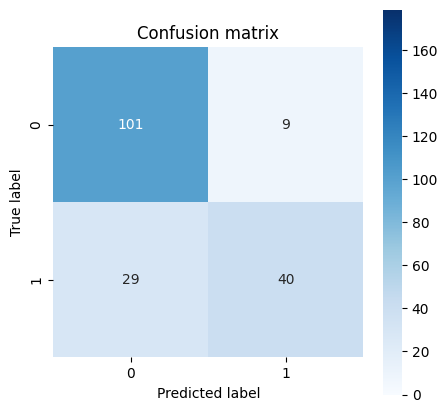

In [ ]:
show_confusion_matrix(val_df["Survived"].values, y_pred)

In [ ]:
val_df["Survived"].value_counts()

,count
Survived,
0,110
1,69


**Remarks**
- **True Positives (TP):** 40/69 instances of Class 1 were correctly predicted as Class 1.
- **True Negatives (TN):** 101/110 instances of Class 0 were correctly predicted as Class 0.
- **False Positives (FP):** 9 instances of Class 0 were incorrectly predicted as Class 1 (Type I error).
- **False Negatives (FN):** 29 instances of Class 1 were incorrectly predicted as Class 0 (Type II error).

**Summary:** The model appears better at detecting Class 0 than Class 1 because it is affected by the imbalance between the two classes.

## 3.4Classification Report

In [ ]:
print(classification_report(val_df["Survived"].values, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       110
           1       0.82      0.58      0.68        69

    accuracy                           0.79       179
   macro avg       0.80      0.75      0.76       179
weighted avg       0.79      0.79      0.78       179



**Remarks**

**1. Class 0 Performance**
- Precision = 0.78: Meaning most predicted instances for class 0 are correct.
- Recall = 0.92: Showing the model captures most actual instances of class 0.
- F1-Score = 0.84: Indicates a strong balance between precision and recall.

**1. Class 1 Performance**
- Precision = 0.82: Higher than class 0.
- Recall = 0.58: Very lower than class 0, indicating the model misses some true instances of class 1.
- F1-Score = 0.68: Reflects a imbalance between precision and recall for class 1.

**3. Overall Metrics**
- Accuracy = 0.79: Indicates 79% of all predictions are correct.
- Macro Avg: Precision: 0.80, Recall: 0.75, F1-Score: 0.76 — Suggests the model performs fairly consistently across both classes but has slightly lower recall overall.
- Weighted Avg: Precision, Recall are 0.79 and F1-Score is 0.78, reflecting that the metric is weighted by the class distribution (more samples in class 0).

**Summary:** The model performs better on class 0 than class 1. Class 1's lower recall suggests the model struggles to identify all positive instances.

## 3.5ROC Curve and AUC Scores

AUC: 0.865


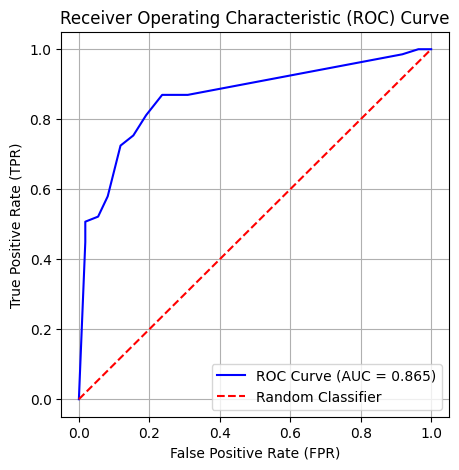

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(val_df["Survived"].values, y_pred_proba)

# Calculate AUC
auc = roc_auc_score(val_df["Survived"].values, y_pred_proba)
print(f"AUC: {auc:.3f}")

# Plot ROC Curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Remarks**

**1. AUC Value:** The AUC is 0.865, which is quite good. It indicates that the model has an 86.5% probability of distinguishing between the two classes (class 0 and class 1).

**2. Shape of the ROC Curve:** The curve is well above the diagonal line (red dashed line, representing a random classifier), confirming that the model performs significantly better than random guessing.

**3. Trade-off Between TPR and FPR:** The curve shows a good balance between the True Positive Rate (TPR) and False Positive Rate (FPR), particularly in the middle range, which means the model performs reliably across different thresholds.

# 4.Model structure and feature importance

In [ ]:
%set_cell_height 300

model.summary()

<IPython.core.display.Javascript object>

Model: "cart_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	Age
	Embarked
	FamilySize
	Fare
	Pclass
	Sex
	Title_Name

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "Title_Name"  1.000000 ################
    2.     "Pclass"  0.394737 ###
    3.       "Fare"  0.294118 
    4.        "Age"  0.254237 
    5. "FamilySize"  0.250000 

Variable Importance: NUM_AS_ROOT:
    1. "Title_Name"  1.000000 

Variable Importance: NUM_NODES:
    1.       "Fare"  5.000000 ################
    2.        "Age"  3.000000 #####
    3. "FamilySize"  2.000000 
    4.     "Pclass"  2.000000 
    5. "Title_Name"  2.000000 

Variable Importance: SUM_SCORE:
    1. "Tit

Variable importances generally indicate how much a feature contributes to the model predictions or quality.

In [ ]:
inspector = model.make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


 Display the important features for the Variable Importance `NUM_AS_ROOT`.

 The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

The list is sorted from the most important to the least. From the output, can infer that the feature at the top of the list is used as the root node in most number of trees than any other feature.


In [ ]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("Title_Name" (4; #6), 1.0)]

# 5.Hyper-parameter tuning

We will choose values ​​for the hyperparameters: `min_examples`, `categorical_algorithm` and `max_depth` of Decision Tree Classifier.

In [ ]:
%set_cell_height 300

tuner = tfdf.tuner.RandomSearch(num_trials=20)

# Hyper-parameters to optimize.
tuner.choice("min_examples", np.arange(1, 21).tolist())
tuner.choice("categorical_algorithm", ["RANDOM", "CART", "ONE_HOT"])
tuner.choice("max_depth", np.arange(1, 21).tolist())

tuning_model = tfdf.keras.CartModel(task=tfdf.keras.Task.CLASSIFICATION, tuner=tuner)

tuning_model.compile(metrics=["accuracy"])

tuning_model_history = tuning_model.fit(x=train_ds, validation_data=val_ds)

print(tuning_model.summary())

<IPython.core.display.Javascript object>

Use /tmp/tmph6tvjc19 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.311510. Found 712 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(179, shape=(), dtype=int32)
Validation dataset read in 0:00:00.403029. Found 179 examples.
Training model...
Model trained in 0:00:00.174442
Compiling model...
Model compiled.
Model: "cart_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	Age
	Embarked
	FamilySize
	Fare
	Pclass
	Sex
	Title_Name

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "Title_Name"  1.000000 ################
    2.     "Pclass"  0.400000 ####
    3. "FamilySize"  0.295

In [ ]:
tuning_model_evaluation = tuning_model.evaluate(val_ds, return_dict=True)

for name, value in tuning_model_evaluation.items():
  print(f"{name}: {value}")

1/1 [==============================] - 0s 222ms/step - loss: 0.0000e+00 - accuracy: 0.8547
loss: 0.0
accuracy: 0.8547486066818237


In [ ]:
inspector = tuning_model.make_inspector()
[field for field in dir(inspector) if not field.startswith("_")]

['MODEL_NAME',
 'dataspec',
 'directory',
 'evaluation',
 'export_to_tensorboard',
 'extract_all_trees',
 'extract_tree',
 'features',
 'file_prefix',
 'header',
 'iterate_on_nodes',
 'label',
 'label_classes',
 'metadata',
 'model_type',
 'num_trees',
 'objective',
 'specialized_header',
 'task',
 'training_logs',
 'tuning_logs',
 'variable_importances',
 'winner_take_all_inference']

In [ ]:
tuning_logs_df = inspector.tuning_logs()
tuning_logs_df.loc[tuning_logs_df['score'] == np.max(tuning_logs_df['score'])]

,score,evaluation_time,best,min_examples,categorical_algorithm,max_depth
17,0.882345,0.121758,True,1,ONE_HOT,13


# 6.Re-train model with Tuning Hyper-parameter

In [ ]:
new_model = tfdf.keras.CartModel(
    task=tfdf.keras.Task.CLASSIFICATION,
    min_examples=1,
    categorical_algorithm="ONE_HOT",
    max_depth=13
)

new_model.compile(metrics=["accuracy"])

new_model_history = new_model.fit(x=train_ds)

Use /tmp/tmprx_9dpko as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.503021. Found 712 examples.
Training model...
Model trained in 0:00:00.065164
Compiling model...
Model compiled.


In [ ]:
new_model_evaluation = new_model.evaluate(val_ds, return_dict=True)

for name, value in new_model_evaluation.items():
  print(f"{name}: {value}")

1/1 [==============================] - 0s 239ms/step - loss: 0.0000e+00 - accuracy: 0.8212
loss: 0.0
accuracy: 0.8212290406227112


In [ ]:
y_pred_proba = new_model.predict(val_ds)

y_pred = np.where(y_pred_proba > 0.5, 1, 0)
y_pred = y_pred.reshape(-1)

print(classification_report(val_df["Survived"].values, y_pred))

1/1 [==============================] - 0s 104ms/step
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       110
           1       0.86      0.64      0.73        69

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.83      0.82      0.81       179



**Remarks:** It can be seen that the evaluation metrics of the new model are higher than the previous model.

In [ ]:
# Save results for comparison between models
from sklearn.metrics import precision_score, recall_score, f1_score

result_metrics = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

new_row = pd.DataFrame({
    'Model': 'CART',
    'Accuracy': accuracy_score(val_df["Survived"].values, y_pred),
    'Precision': precision_score(val_df["Survived"].values, y_pred),
    'Recall': recall_score(val_df["Survived"].values, y_pred),
    'F1-Score': f1_score(val_df["Survived"].values, y_pred)
}, index=[len(result_metrics)])

result_metrics = pd.concat([result_metrics, new_row], ignore_index=True)

result_metrics

<ipython-input-46-d8cc6dd770af>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_metrics = pd.concat([result_metrics, new_row], ignore_index=True)


,Model,Accuracy,Precision,Recall,F1-Score
0,CART,0.821229,0.862745,0.637681,0.733333


In [ ]:
result_metrics.to_csv('/content/drive/MyDrive/Basic ML/source codes/result_metrics.csv', index=False)